In [1]:
## Imports

In [2]:
import xarray as xr

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgcm
from typing import Annotated
from xhistogram.xarray import histogram

In [3]:
## Open the data

In [4]:
# data in persistent bucket
target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_renorm_48hr.zarr'

In [5]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [6]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

/tmp/ipykernel_696/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_696/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_696/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] -

In [7]:
## Expectation values

In [8]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = pdf['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = pdf['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = pdf['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf

def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dims=dims)

In [9]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

In [10]:
## Look at summer hemisphere

In [11]:
lats = hist_ds['vertices_latitude'].isel(vertices=0).compute()
lats.where((lats>-5)&(lats<5),drop=True)['region_num']

<xarray.DataArray 'region_num' (region: 21)> Size: 168B
array([ 71,  79, 263, 271, 279, 287, 303, 311, 319, 520, 521, 522, 523, 524,
       525, 526, 527, 712, 713, 714, 715])
Coordinates:
    face                (region) int64 168B 1 1 4 4 4 4 4 ... 8 8 8 11 11 11 11
    i_region_coarse     (region) int64 168B 0 1 0 1 2 3 5 6 ... 1 1 1 1 1 1 1 1
    j_region_coarse     (region) int64 168B 7 7 7 7 7 7 7 7 ... 4 5 6 7 0 1 2 3
  * region_num          (region) int64 168B 71 79 263 271 ... 712 713 714 715
    vertices_latitude   (region) float32 84B 3.488 3.488 3.488 ... 3.468 3.468
    vertices_longitude  (region) float32 84B -37.99 -26.74 ... -105.5 -94.24
Dimensions without coordinates: region

/tmp/ipykernel_696/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_696/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_696/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_696/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] -

In [13]:
hist_ds.sel(region_num = 71)['vertices_latitude'].values

array([ 3.4877594,  3.4877594, 13.728166 , 13.728166 ], dtype=float32)

In [14]:
hist_ds.sel(region_num = 71)['vertices_longitude'].values

array([-37.989582, -26.760416, -26.760416, -37.989582], dtype=float32)

In [17]:
#Jan/Feb/Mar
JFM_65 = hist_ds.sel(region_num = 71)['histogram_vort_strain_div'].isel(time=11)#slice(11,20)).mean('time')

In [18]:
hist_ds.sel(region_num = 71)['histogram_vort_strain_div'].isel(time=slice(11,20)).time

<xarray.DataArray 'time' (time: 9)> Size: 72B
array(['2012-01-05T00:00:00.000000000', '2012-01-15T00:00:00.000000000',
       '2012-01-25T00:00:00.000000000', '2012-02-04T00:00:00.000000000',
       '2012-02-14T00:00:00.000000000', '2012-02-24T00:00:00.000000000',
       '2012-03-05T00:00:00.000000000', '2012-03-15T00:00:00.000000000',
       '2012-03-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    face             int64 8B dask.array<chunksize=(), meta=np.ndarray>
    i_region_coarse  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    j_region_coarse  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    region_num       int64 8B 71
  * time             (time) datetime64[ns] 72B 2012-01-05 ... 2012-03-25

In [19]:
JFM_65_DivPdf = (JFM_65*JFM_65.div_bin).mean('div_bin').load()
#JFM_65_DivPdf2 = JFM_65_DivPdf.where(JFM_65_DivPdf>2*10**-3).load()

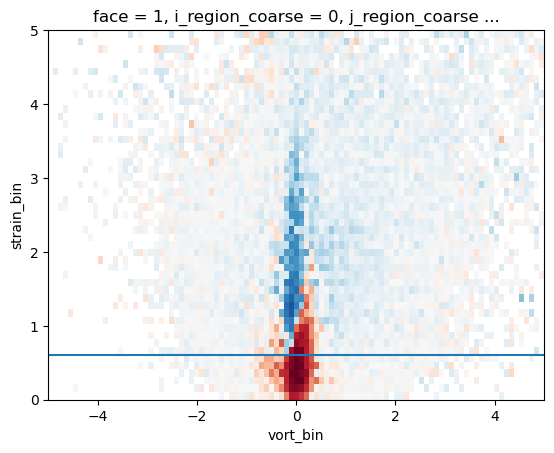

In [20]:
JFM_65_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
plt.axhline(0.6)

In [21]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid
    

In [22]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [23]:
grid = xgcm.Grid(ds_grid, periodic=False)

In [24]:



@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [25]:

def vort_strain_div_bins(n_strain_bins=100, n_vort_bins=200, n_div_bins=200, vort_max=5, strain_max=5, div_max=5):
    vort_bins = np.linspace(-vort_max, vort_max, n_vort_bins)
    strain_bins = np.linspace(0.0, strain_max, n_strain_bins)
    div_bins = np.linspace(-div_max, div_max, n_div_bins)
    return vort_bins, strain_bins, div_bins

In [26]:
vort_bins, strain_bins, div_bins = vort_strain_div_bins(n_strain_bins=50, n_vort_bins=100, n_div_bins=100)
a = np.diff(vort_bins)[0]*np.diff(strain_bins)[0]*np.diff(div_bins)[0]

In [45]:
ds.isel(time=2736).sel(face=1).isel(j=slice(3780,4320)).isel(i=slice(0,550)).XC.max().values#

array(-26.552084, dtype=float32)

In [27]:
ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [47]:
#σ_piece = σ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(550,1100)).rename({"i_g": "i", "j_g": "j"})/10**-4
#ζ_piece = ζ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(550,1100)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
#D_piece = D.isel(time=2736).sel(face=1).isel(i=slice(0,550)).isel(j=slice(550,1100))/10**-4

σ_piece = σ.isel(time=2736).sel(face=1).isel(j_g=slice(3780,4320)).isel(i_g=slice(0,550)).rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece = ζ.isel(time=2736).sel(face=1).isel(j_g=slice(3780,4320)).isel(i_g=slice(0,550)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece = D.isel(time=2736).sel(face=1).isel(j=slice(3780,4320)).isel(i=slice(0,550))/10**-4

In [48]:
h = histogram(
    ζ_piece.rename('vort'),
    σ_piece.rename('strain'),
    D_piece.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/550/550

In [49]:
vort_bins

array([-5.        , -4.8989899 , -4.7979798 , -4.6969697 , -4.5959596 ,
       -4.49494949, -4.39393939, -4.29292929, -4.19191919, -4.09090909,
       -3.98989899, -3.88888889, -3.78787879, -3.68686869, -3.58585859,
       -3.48484848, -3.38383838, -3.28282828, -3.18181818, -3.08080808,
       -2.97979798, -2.87878788, -2.77777778, -2.67676768, -2.57575758,
       -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
       -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657,
       -1.46464646, -1.36363636, -1.26262626, -1.16161616, -1.06060606,
       -0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
       -0.45454545, -0.35353535, -0.25252525, -0.15151515, -0.05050505,
        0.05050505,  0.15151515,  0.25252525,  0.35353535,  0.45454545,
        0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
        1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,
        1.56565657,  1.66666667,  1.76767677,  1.86868687,  1.96

In [50]:
h_DivPdf = (h*h.div_bin).mean('div_bin').load()

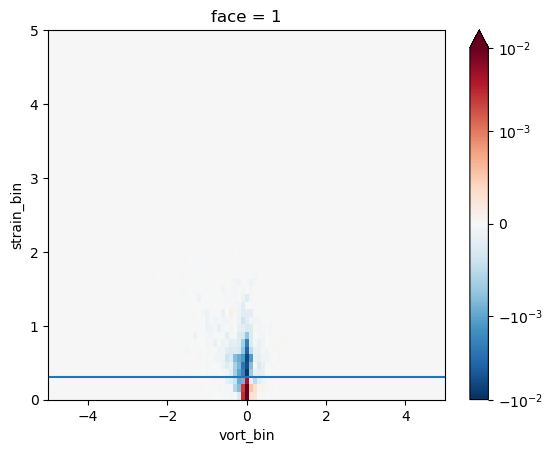

In [51]:
h_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)
#plt.axhline(1)
plt.gcf().savefig('jpdf_region.png')

In [63]:
ds

<xarray.Dataset> Size: 18TB
Dimensions:  (time: 9030, face: 13, j: 4320, i_g: 4320, j_g: 4320, i: 4320)
Coordinates:
  * face     (face) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j        (j) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 72kB 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
Data variables:
    U        (time, face, j, i_g) float32 9TB dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    V        (time, face, j_g, i) float32 9TB dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

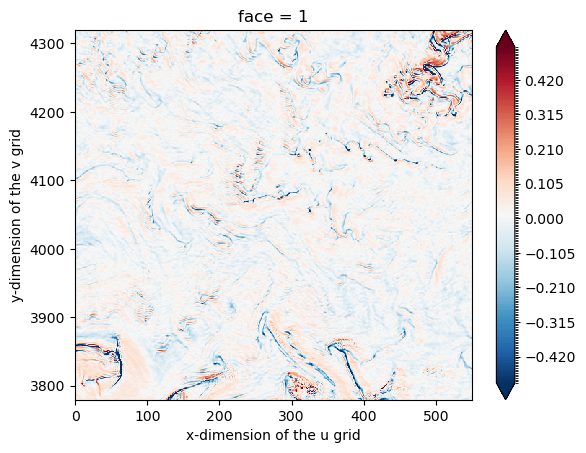

In [53]:
ζ_piece.plot(levels=np.arange(-1,1.05,0.01)*0.5)
plt.gcf().savefig('vort_region.png')

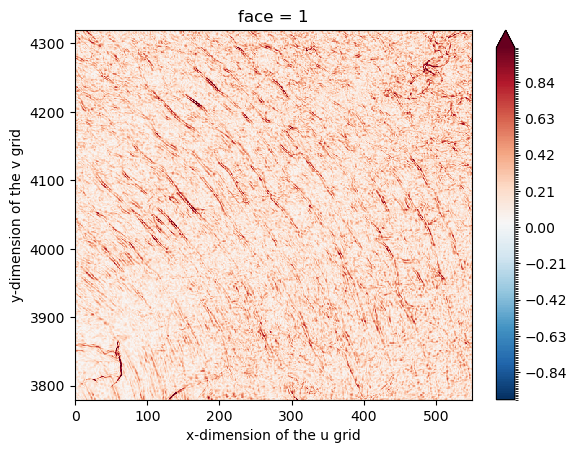

In [54]:
σ_piece.plot(levels=np.arange(-1,1.05,0.01))
plt.gcf().savefig('strain_region.png')

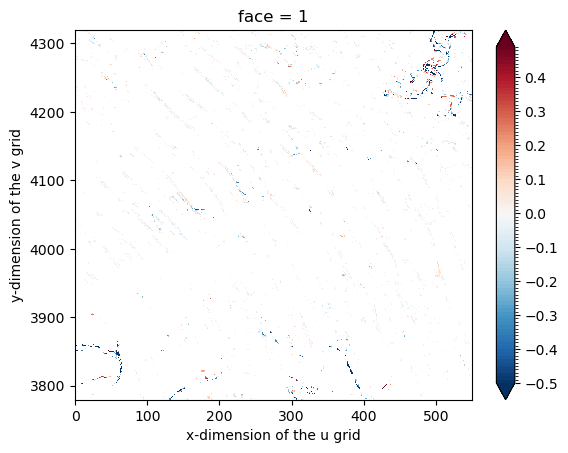

In [56]:
ζ_piece.where((σ_piece>0.5)&(σ_piece<1)).plot(levels=np.arange(-0.5,0.5,0.01))

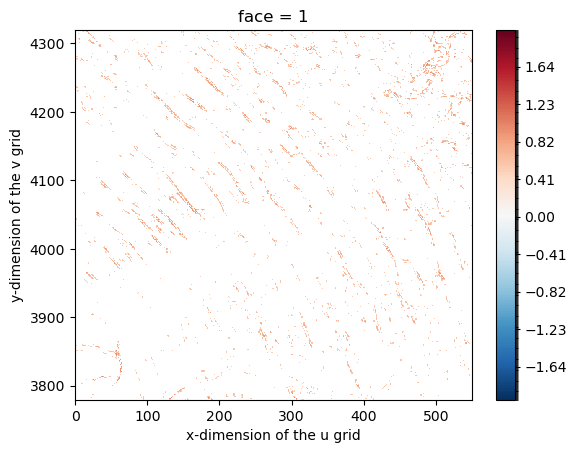

In [58]:
σ_piece.where((σ_piece>0.5)&(σ_piece<1)).plot(levels=np.arange(-2,2.05,0.01))

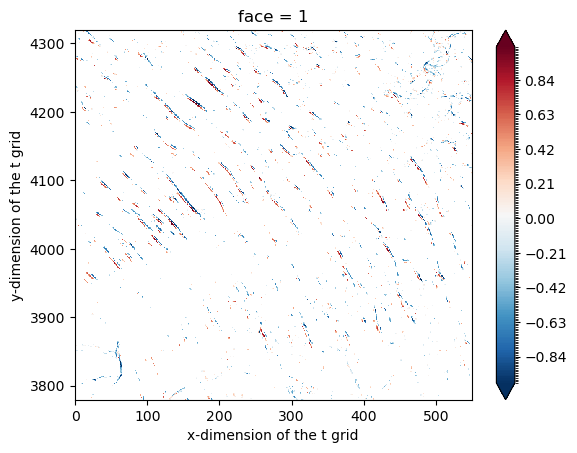

In [60]:
D_piece.where((σ_piece>0.5)).plot(levels=np.arange(-1,1.05,0.01))

In [61]:
import matplotlib.patches as patches

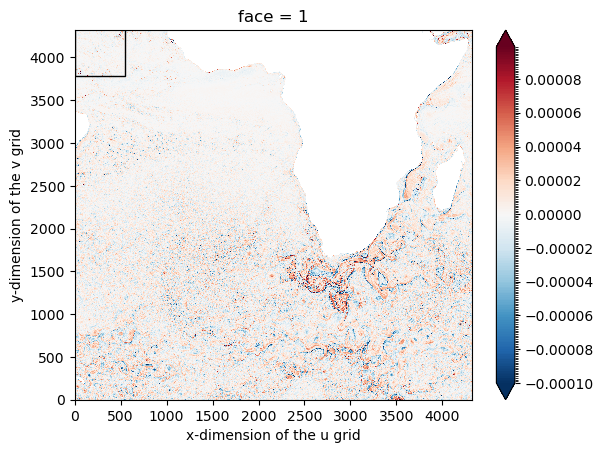

In [62]:

ζ.isel(time=2736).sel(face=1).plot(levels=np.arange(-1,1,0.01)*0.0001)
rect = patches.Rectangle((0, 3780), 550, 550, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect)
plt.gcf().savefig('region_loc.png')

In [94]:
## Make gifs

In [48]:
σ_piece2 = σ.isel(time=slice(2736, 2786)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece2 = ζ.isel(time=slice(2736, 2786)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece2 = D.isel(time=slice(2736, 2786)).sel(face=1).isel(i=slice(0,550)).isel(j=slice(1100,1650))/10**-4

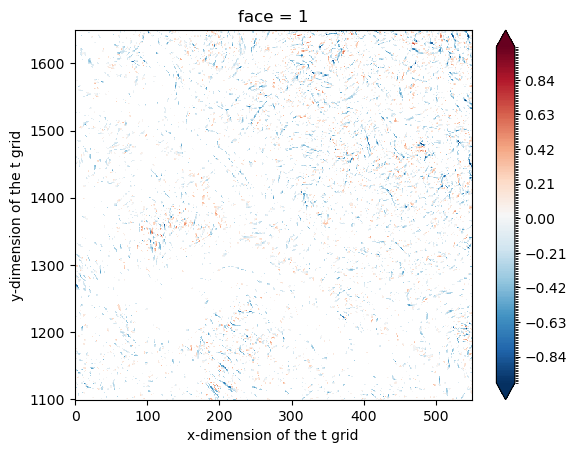

In [49]:
for t in range(0,50):
    plt.clf()
    D_piece2.where(σ_piece2>0.3).isel(time=t).plot(levels=np.arange(-1,1.05,0.01))
    plt.gcf().savefig('div_piece_movie/div_movie_n_%02d.png' % (t))

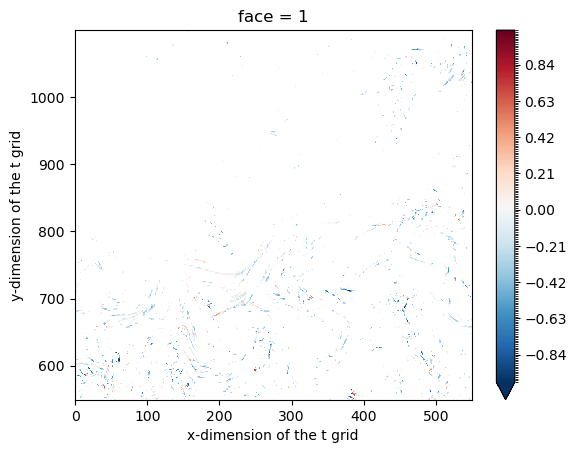

In [101]:
t=0
D_piece2.where((σ_piece2>0.5)&(σ_piece2<1)).isel(time=t).plot(levels=np.arange(-1,1.05,0.01))